In [1]:
from pathlib import Path

import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

import h5py as h5

import numba as nb
ak.numba.register_and_check()

In [2]:
proj_dir = Path.cwd().parent.parent

infile_path = proj_dir.joinpath('reports/bv2/hhh_test.h5')
predfile_path = proj_dir.joinpath('reports/bv2/pred_v22.h5')

plot_dir = proj_dir.joinpath('reports/bv2/figures')

In [3]:
infile = h5.File(infile_path)
predfile = h5.File(predfile_path)

In [4]:
infile['TARGETS']['h1'].keys()

<KeysViewHDF5 ['b1', 'b2', 'mask', 'pt']>

In [5]:
predfile['TARGETS']['bh2'].keys()

<KeysViewHDF5 ['assignment_probability', 'bb', 'detection_probability', 'marginal_probability']>

In [6]:
infile['INPUTS']['BoostedJets'].keys()

<KeysViewHDF5 ['MASK', 'fj_charge', 'fj_chargedenergyfrac', 'fj_cosphi', 'fj_ehadovereem', 'fj_eta', 'fj_mass', 'fj_ncharged', 'fj_neutralenergyfrac', 'fj_nneutral', 'fj_phi', 'fj_pt', 'fj_sdmass', 'fj_sinphi', 'fj_tau21', 'fj_tau32']>

In [7]:
predfile["TARGETS"]["bh1"]['bb'][0:100]

array([ 0,  6,  6, 10, 10,  4,  2,  6, 11,  7,  5, 10,  1,  6,  7, 10, 10,
        6, 10,  0, 10,  5,  1,  1,  6,  4, 12,  3, 11, 10, 11, 10, 10,  4,
       10, 10, 10, 10, 10,  4,  8,  0,  1,  1,  6, 10,  6, 10,  2,  1,  0,
       11,  3,  7,  3,  9, 10,  5, 10,  4,  5,  0,  6,  0, 11, 12,  0, 11,
        6,  0, 11,  2,  2, 10, 11,  8,  0,  3,  7, 10,  1, 10,  4, 11, 10,
        3, 10,  6,  0,  5, 10, 10,  0,  1, 11, 10,  0,  0,  1,  5])

In [8]:
infile["TARGETS"]["bh1"]['mask'][0:100]

array([False, False,  True, False, False, False, False, False,  True,
        True, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [9]:
infile["TARGETS"]["bh1"]['bb'][0:100]

array([-1, -1,  0, -1, -1, -1, -1, -1,  0,  1, -1, -1, -1, -1, -1, -1,  0,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,
       -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [10]:
(predfile["TARGETS"]["bh1"]['bb'][:100][infile["TARGETS"]["bh1"]['mask'][:100]]-10)==infile["TARGETS"]["bh1"]['bb'][:100][infile["TARGETS"]["bh1"]['mask'][:100]]

array([False, False, False,  True,  True, False,  True])

### Test if indices in pred bb are out of boundary for target mask =True

In [11]:
predfile["TARGETS"]["bh2"]['bb'][0:100]

array([ 2, 10, 11,  6,  7,  3,  4, 11, 12, 10,  8,  6,  3,  0,  2,  7,  6,
        2,  7,  2,  6,  1,  3,  0, 11,  2, 10,  1,  6,  5,  2,  7, 12,  3,
        7,  6,  6,  7,  6, 10,  2,  1,  3,  0,  2,  8, 10,  9,  3,  4,  1,
        5,  6,  6,  6, 10,  4,  8,  5,  3,  0,  1, 11,  1, 10, 11,  2,  7,
       10,  1,  6,  3,  1,  4, 10,  0, 10,  4,  3,  6,  2, 11,  2,  6,  8,
        2,  7, 10,  2, 11,  7,  4,  4,  0,  6,  4,  1,  2,  4, 10])

### OptionL: examaine pt order

### Obtain python arrays for calculating purity and efficiency

In [12]:
# Collect H pt, mask, target and predicted jet and fjets for 3 Hs in each event
# h pt
h1_pt = np.array(infile['TARGETS']['h1']['pt'])
h2_pt = np.array(infile['TARGETS']['h2']['pt'])
h3_pt = np.array(infile['TARGETS']['h3']['pt'])

bh1_pt = np.array(infile['TARGETS']['bh1']['pt'])
bh2_pt = np.array(infile['TARGETS']['bh2']['pt'])
bh3_pt = np.array(infile['TARGETS']['bh3']['pt'])

# mask
h1_mask = np.array(infile['TARGETS']['h1']['mask'])
h2_mask = np.array(infile['TARGETS']['h2']['mask'])
h3_mask = np.array(infile['TARGETS']['h3']['mask'])

bh1_mask = np.array(infile['TARGETS']['bh1']['mask'])
bh2_mask = np.array(infile['TARGETS']['bh2']['mask'])
bh3_mask = np.array(infile['TARGETS']['bh3']['mask'])

# target jet/fjets
b1_h1_t = np.array(infile["TARGETS"]["h1"]['b1'])
b1_h2_t = np.array(infile["TARGETS"]["h2"]['b1'])
b1_h3_t = np.array(infile["TARGETS"]["h3"]['b1'])

b2_h1_t = np.array(infile["TARGETS"]["h1"]['b2'])
b2_h2_t = np.array(infile["TARGETS"]["h2"]['b2'])
b2_h3_t = np.array(infile["TARGETS"]["h3"]['b2'])

bb_bh1_t = np.array(infile["TARGETS"]["bh1"]['bb'])
bb_bh2_t = np.array(infile["TARGETS"]["bh2"]['bb'])
bb_bh3_t = np.array(infile["TARGETS"]["bh3"]['bb'])

# pred jet/fjets
b1_h1_p = np.array(predfile["TARGETS"]["h1"]['b1'])
b1_h2_p = np.array(predfile["TARGETS"]["h2"]['b1'])
b1_h3_p = np.array(predfile["TARGETS"]["h3"]['b1'])

b2_h1_p = np.array(predfile["TARGETS"]["h1"]['b2'])
b2_h2_p = np.array(predfile["TARGETS"]["h2"]['b2'])
b2_h3_p = np.array(predfile["TARGETS"]["h3"]['b2'])

bb_bh1_p = np.array(predfile["TARGETS"]["bh1"]['bb'])
bb_bh2_p = np.array(predfile["TARGETS"]["bh2"]['bb'])
bb_bh3_p = np.array(predfile["TARGETS"]["bh3"]['bb'])


# fatjet assignment probability
ap_bh1 = np.array(predfile["TARGETS"]["bh1"]['assignment_probability'])
ap_bh2 = np.array(predfile["TARGETS"]["bh2"]['assignment_probability'])
ap_bh3 = np.array(predfile["TARGETS"]["bh3"]['assignment_probability'])

In [13]:
# collect fatjet pt
fj_pt = np.array(infile['INPUTS']['BoostedJets']['fj_pt'])

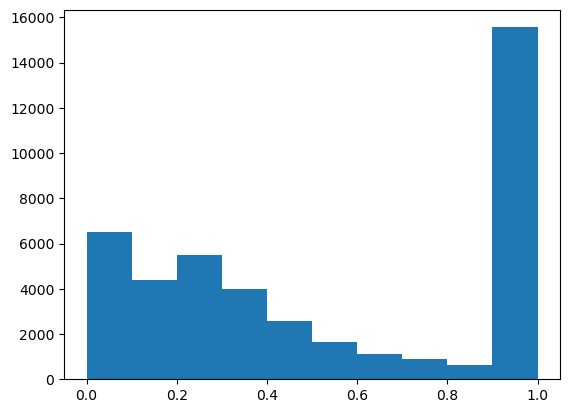

In [14]:
plt.hist(ap_bh1)
plt.show()

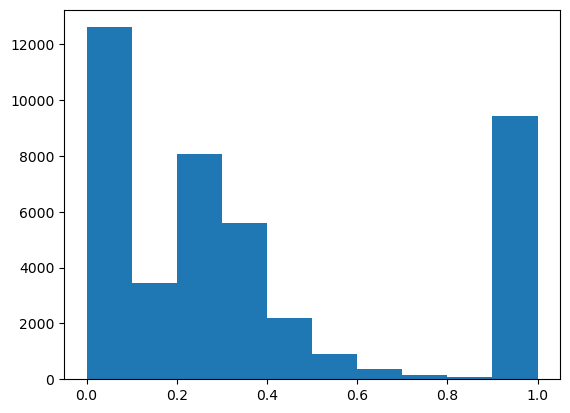

In [15]:
plt.hist(ap_bh2)
plt.show()

# Calculating efficiency (denominator should be pred)

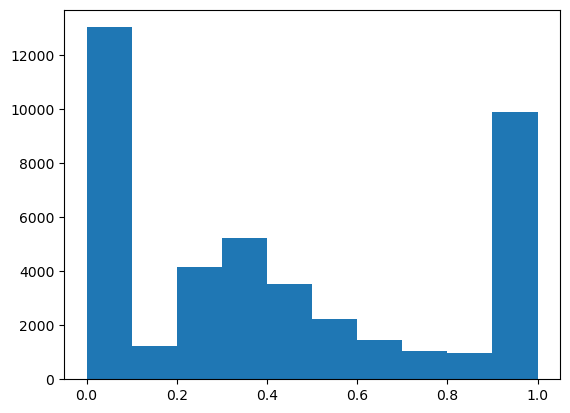

In [16]:
plt.hist(ap_bh3)
plt.show()

### As prediction h1 can be matched to target h1, 2, 3,  I will do things in the event level first

In [17]:
# convert some arrays to ak array
ap = np.concatenate((ap_bh1.reshape(-1,1), ap_bh2.reshape(-1,1), ap_bh3.reshape(-1,1)), axis=1)
ap = ak.Array(ap)
bb_p = np.concatenate((bb_bh1_p.reshape(-1,1), bb_bh2_p.reshape(-1,1), bb_bh3_p.reshape(-1,1)), axis=1)
bb_p = ak.Array(bb_p)
bb_t = np.concatenate((bb_bh1_t.reshape(-1,1), bb_bh2_t.reshape(-1,1), bb_bh3_t.reshape(-1,1)), axis=1)
bb_t = ak.Array(bb_t)
fj_pt = ak.Array(fj_pt)
print(fj_pt.type)

# p: prediction
AP_threshold = 0.5
ap_filter = ap > AP_threshold
bb_p_passed = bb_p.mask[ap_filter]
bb_p_passed = ak.drop_none(bb_p_passed)

ap_passed = ap.mask[ap_filter]
ap_passed = ak.drop_none(ap_passed)

sort_by_ap = ak.argsort(ap_passed, axis=-1, ascending=False)
bb_p_passed = bb_p_passed[sort_by_ap]

42829 * 3 * float32


In [18]:
bh_eff = []
# for each event
for bb_p_event, bb_t_event, fj_pt_event in zip(bb_p_passed, bb_t, fj_pt):
    # for each predicted fatjet, check if the targets have a t fatject same with the p fatjet
    for bb_p in bb_p_event:
        match = 0
        for bb_t in bb_t_event:
            if bb_p == bb_t+10:
                match = 1
        bh_eff.append([fj_pt_event[bb_t-1], match])
bh_eff = np.array(bh_eff)

In [19]:
# set x axis (pT) of the scattered points
bins = np.arange(200, 1000, 100)
bin_centers = [(bins[i]+bins[i+1])/2 for i in range(bins.size-1)]

# group points into bins by fatjet pT
inds = np.digitize(bh_eff[:,0], bins)

#np.concatenate((ap_bh1.reshape(-1,1), ap_bh2.reshape(-1,1), ap_bh3.reshape(-1,1)), axis=1)
effs_per_bin = []
for bin_i in range(1, len(bins)):
    effs_per_bin.append(bh_eff[:,1][inds==bin_i])
effs_per_bin = ak.Array(effs_per_bin)

In [20]:
for effs, bin_c in zip(effs_per_bin, bin_centers):
    print(f"{ak.sum(effs)} out of {ak.count(effs)} are matched in bin centered at {bin_c} GeV")

2095.0 out of 12415 are matched in bin centered at 250.0 GeV
1772.0 out of 4804 are matched in bin centered at 350.0 GeV
1095.0 out of 2281 are matched in bin centered at 450.0 GeV
525.0 out of 1044 are matched in bin centered at 550.0 GeV
287.0 out of 547 are matched in bin centered at 650.0 GeV
161.0 out of 293 are matched in bin centered at 750.0 GeV
87.0 out of 167 are matched in bin centered at 850.0 GeV


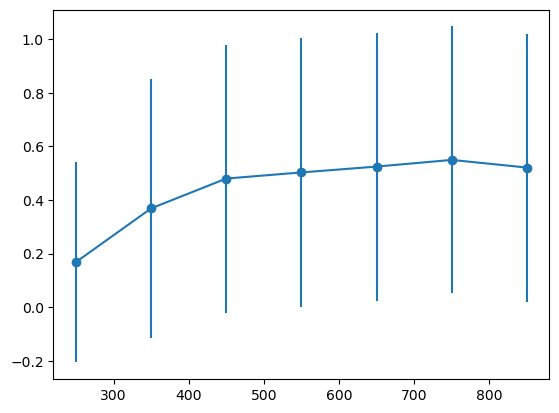

In [21]:
plt.scatter(x=bin_centers, y=ak.mean(effs_per_bin, axis=-1))
plt.errorbar(x=bin_centers, y=ak.mean(effs_per_bin, axis=-1), yerr=ak.std(effs_per_bin, axis=-1))
plt.show()

In [23]:
ak.std(effs_per_bin, axis=-1)

<Array [0.375, 0.482, 0.5, 0.5, 0.499, 0.498, 0.5] type='7 * float64'>

# Calculating purity 

In [22]:
# get the truth level boosted higgs mask
bh_mask = np.concatenate((bh1_mask.reshape(-1,1), bh2_mask.reshape(-1,1), bh3_mask.reshape(-1,1)), axis=1)
bh_mask = ak.Array(bh_mask)

# applying masks to the target bh's bb indices:
bb_bh_t_selected = bb_bh_t.mask[bh_mask]
bb_bh_t_selected = ak.drop_none(bb_bh_t_selected)

bh_pt = np.concatenate((bh1_pt.reshape(-1,1), bh2_pt.reshape(-1,1), bh3_pt.reshape(-1,1)), axis=1)
bh_pt = ak.Array(bh_pt)

NameError: name 'bb_bh_t' is not defined